In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
from datetime import datetime


sample_walls = [
    geo.Polygon(
        [[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1]],
        [1, 0, 0], [0, 1, 0]),
    geo.Polygon(
        [[0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]],
        [1, 0, 0], [0, -1, 0]),
    geo.Polygon(
        [[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]],
        [1, 0, 0], [0, 0, 1]),
    geo.Polygon(
        [[0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]],
        [1, 0, 0], [0, 0, -1]),
    geo.Polygon(
        [[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0]],
        [0, 0, 1], [1, 0, 0]),
    geo.Polygon(
        [[1, 0, 0], [1, 0, 1], [1, 1, 1], [1, 1, 0]],
        [0, 0, 1], [-1, 0, 0]),
]




In [3]:
def calc_form_factor(rad):
    if len(rad.patch_list) > 1:
        for patches in rad.patch_list:
            patches.calculate_form_factor(rad.patch_list)

In [4]:
# test for form factor
import numpy as np
max_sizes = 1/(2**np.arange(0, 5))
# max_sizes = np.array([0.1, 0.01])
fast_first = np.zeros_like(max_sizes)
fast_second = np.zeros_like(max_sizes)
slow = np.zeros_like(max_sizes)
number_of_patches = np.zeros_like(max_sizes)
repeat = 10
for i, max_size in enumerate(max_sizes):
    print(f'run: {max_size}')
    # run fast two times
    radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
    radiosity.check_visibility()
    start = datetime.now()
    radiosity.calculate_form_factors()
    fast_first[i] = (datetime.now() - start).microseconds
    start = datetime.now()
    for _ in range(repeat):
        radiosity.calculate_form_factors()
    fast_second[i] = (datetime.now() - start).microseconds/repeat
    number_of_patches[i] = radiosity.n_patches
    # Run old
    if max_size > 0.1:
        radiosity_old = Radiosity(sample_walls, max_size, 0, 1)
        start = datetime.now()
        for _ in range(repeat):
            calc_form_factor(radiosity_old)
        slow[i] = (datetime.now() - start).microseconds/repeat

run: 1.0


/Users/anne/git/_pyfar/sparapy/sparapy/geometry.py:14: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
/Users/anne/git/_pyfar/sparapy/sparapy/geometry.py:14: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


run: 0.5
run: 0.25
run: 0.125
run: 0.0625


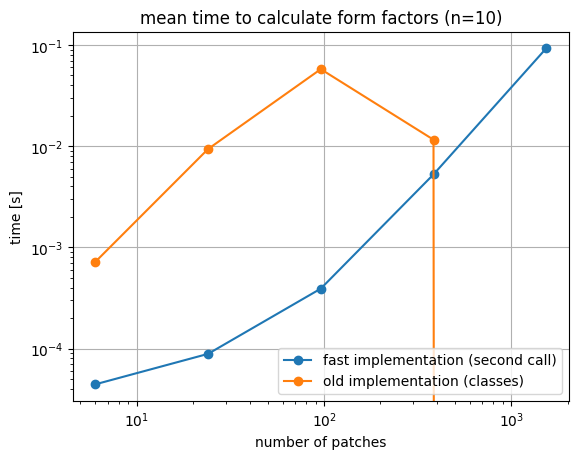

In [5]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.gca()
# ax.semilogy(number_of_patches, fast_first*1e-6, label='fast implementation (first call)')
ax.semilogy(number_of_patches, fast_second*1e-6, label='fast implementation (second call)', marker='o')
ax.semilogy(number_of_patches, slow*1e-6, label='old implementation (classes)', marker='o')
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('time [s]')
ax.set_title(f'mean time to calculate form factors (n={repeat})')
plt.legend()

In [6]:
# its x times faster for each setting
slow/fast_second

array([ 16.22573363, 105.74604966, 147.67664364,   2.20340272,
         0.        ])